<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/BAFV2data_preprocessing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import random
import os
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.utils import resample

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 2.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'


Mounted at /content/drive


# LOAD DATA & MODEL

In [4]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}


Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


load best light gbm model from variant 2

In [5]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model for variant 2
modelv2 = models.get("model_Variant II_top_4")

print(modelv2)

Model 'model_Variant II_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant II_top_4.pkl
Model 'model_Base_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Base_top_4.pkl
Model 'model_Variant I_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant I_top_4.pkl
Model 'model_Variant V_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant V_top_0.pkl
Model 'model_Variant III_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant III_top_0.pkl
Model 'model_Variant IV_top_6' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/Accuracy/model_Variant IV_top_6.pkl
LGBMClassifier(boo

# Explore data

In [6]:
#rename dataset variant 2 and create a copy
v2 = dataframes["Variant II"]
v2_old = v2.copy()

In [7]:
pd.set_option('display.max_columns', 50) # Increase the maximum number of columns displayed in Pandas to 50
pd.set_option('display.max_rows', 50)
v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [8]:
v2['payment_type'].unique() #remove because obfuscated
v2['days_since_request'].unique() #remove because unclear values

array([0.01673985, 0.01900183, 0.04706417, ..., 0.03555377, 0.02066269,
       0.0074784 ])

In [9]:
print(v2['days_since_request'])

0         0.016740
1         0.019002
2         0.047064
3         0.008007
4         2.513544
            ...   
999995    0.001835
999996    0.023952
999997    0.035554
999998    0.020663
999999    0.007478
Name: days_since_request, Length: 1000000, dtype: float64


In [10]:
v2_old['source'].unique()
v2_old['device_os'].unique()
v2_old['keep_alive_session'].unique()
#v2_old['device_fraud_count'].unique()

array([0, 1])

In [11]:
1 in v2_old['device_fraud_count'].unique()

False

In [12]:
v2_old['device_os'].unique()

array(['other', 'macintosh', 'linux', 'windows', 'x11'], dtype=object)

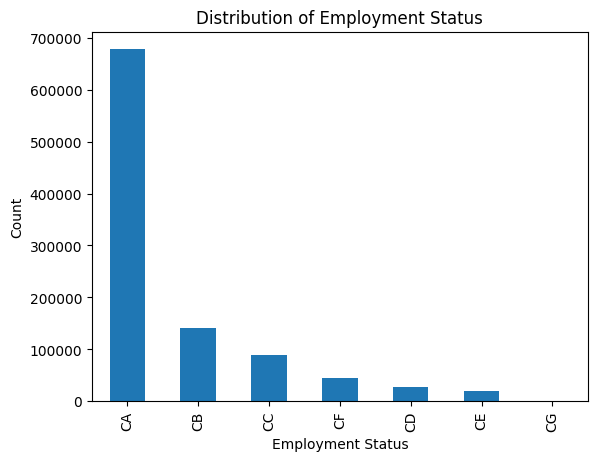

In [56]:
v2_old['employment_status'].value_counts().plot(kind='bar')
plt.title('Distribution of Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.show()

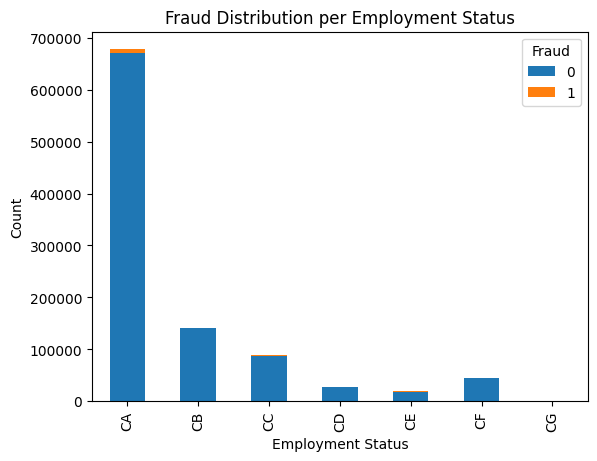

In [57]:
fraud_per_employment = v2_old.groupby(['employment_status', 'fraud_bool']).size().unstack()

fraud_per_employment.plot(kind='bar', stacked=True)
plt.title('Fraud Distribution per Employment Status')
plt.xlabel('Employment Status')
plt.ylabel('Count')
plt.legend(title='Fraud')  # Add a legend to indicate fraud (0 or 1)
plt.show()

Master dataset

In [13]:
#Master dataset
#FEATURES
META = ['clusters', 'new_clusters']
ERROR = ['errors', 'TP', 'TN', 'FN', 'FP']
REG = [ 'session_length_in_minutes', 'email_is_free',
       'proposed_credit_limit','name_email_similarity',
      'zip_count_4w', 'date_of_birth_distinct_emails_4w',
      'phone_mobile_valid', 'has_other_cards', 'foreign_request']
SEN = ['customer_age', 'income'] #protected attributes in BAF paper also employment_status
DUMMY = ['source_INTERNET', 'source_TELEAPP', 'device_os_other', 'device_os_macintosh','device_os_linux','device_os_windows', 'device_os_x11']

#FEATURES SCALED
ERROR_scaled = ['errors_scaled']
REG_scaled = ['session_length_in_minutes_scaled',
              'email_is_free_scaled',
              'proposed_credit_limit_scaled',
              'name_email_similarity_scaled',
              'zip_count_4w_scaled',
              'date_of_birth_distinct_emails_4w_scaled','has_other_cards_scaled', 'foreign_request_scaled']
SEN_scaled = ['customer_age_scaled', 'income_scaled']
DUMMY_scaled = ['source_INTERNET_scaled', 'source_TELEAPP_scaled', 'device_os_other_scaled', 'device_os_macintosh_scaled', 'device_os_linux_scaled', 'device_os_windows_scaled', 'device_os_x11_scaled']


#SHAP FEATURES
SHAP_REG = [
    'Shap_session_length_in_minutes', 'Shap_email_is_free',
    'Shap_proposed_credit_limit', 'Shap_name_email_similarity',
    'Shap_zip_count_4w', 'Shap_date_of_birth_distinct_emails_4w',
    'Shap_phone_mobile_valid', 'Shap_has_other_cards', 'Shap_foreign_request'
]

SHAP_SEN = ['Shap_customer_age', 'Shap_income']

SHAP_DUMMY = [
    'Shap_source_INTERNET', 'Shap_source_TELEAPP',
    'Shap_device_os_other', 'Shap_device_os_macintosh',
    'Shap_device_os_linux', 'Shap_device_os_windows', 'Shap_device_os_x11'
]

#SHAP FEATURES SCALED
SHAP_REG_scaled = ['Shap_session_length_in_minutes_scaled',
    'Shap_email_is_free_scaled', 'Shap_proposed_credit_limit_scaled',
    'Shap_name_email_similarity_scaled', 'Shap_zip_count_4w_scaled',
    'Shap_date_of_birth_distinct_emails_4w_scaled',
    'Shap_phone_mobile_valid_scaled', 'Shap_has_other_cards_scaled',
    'Shap_foreign_request_scaled'
]

SHAP_SEN_scaled = ['Shap_customer_age_scaled', 'Shap_income_scaled']

SHAP_DUMMY_scaled = [
    'Shap_source_INTERNET_scaled', 'Shap_source_TELEAPP_scaled',
    'Shap_device_os_other_scaled', 'Shap_device_os_macintosh_scaled',
    'Shap_device_os_linux_scaled', 'Shap_device_os_windows_scaled',
    'Shap_device_os_x11_scaled'
]

'''removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', '''

"removed features = 'device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',\n'velocity_6h', 'velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',\n'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status, 'bank_branch_count_8w', 'credit_risk_score', 'month', "

In [14]:
#v2_old['housing_status'].unique()
#v2_old['employment_status'].unique()
#v2_old['source'].unique()
v2_old['device_os'].unique()

array(['other', 'macintosh', 'linux', 'windows', 'x11'], dtype=object)

Remove features

In [15]:
features_to_remove = ['device_fraud_count', 'intended_balcon_amount', 'payment_type', 'days_since_request',
'velocity_6h','velocity_24h', 'velocity_4w', 'keep_alive_session', 'prev_address_months_count', 'current_address_months_count', 'phone_home_valid',
'bank_months_count', 'device_distinct_emails_8w', 'housing_status', 'employment_status', 'bank_branch_count_8w', 'credit_risk_score'] #'month' keep for RF

v2 = v2.drop(columns = features_to_remove)

In [16]:
v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   customer_age                      1000000 non-null  int64  
 4   zip_count_4w                      1000000 non-null  int64  
 5   date_of_birth_distinct_emails_4w  1000000 non-null  int64  
 6   email_is_free                     1000000 non-null  int64  
 7   phone_mobile_valid                1000000 non-null  int64  
 8   has_other_cards                   1000000 non-null  int64  
 9   proposed_credit_limit             1000000 non-null  float64
 10  foreign_request                   1000000 non-null  int64  
 11  source                            1000

In [17]:
#get a smaller sample approx like compas
v2_sample = v2.sample(n= 8000, random_state = 42)

In [18]:
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        8000 non-null   int64  
 1   income                            8000 non-null   float64
 2   name_email_similarity             8000 non-null   float64
 3   customer_age                      8000 non-null   int64  
 4   zip_count_4w                      8000 non-null   int64  
 5   date_of_birth_distinct_emails_4w  8000 non-null   int64  
 6   email_is_free                     8000 non-null   int64  
 7   phone_mobile_valid                8000 non-null   int64  
 8   has_other_cards                   8000 non-null   int64  
 9   proposed_credit_limit             8000 non-null   float64
 10  foreign_request                   8000 non-null   int64  
 11  source                            8000 non-null   object 
 12  sess

In [19]:
'''missing_values = v2_sample.isna()
print(missing_values)'''

'missing_values = v2_sample.isna()\nprint(missing_values)'

In [20]:
#print(v2_sample.loc[534950])

Get dummies for objects

In [21]:
dummy_cols = ['source', 'device_os']
v2_sample = pd.get_dummies(v2_sample, columns = dummy_cols)
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        8000 non-null   int64  
 1   income                            8000 non-null   float64
 2   name_email_similarity             8000 non-null   float64
 3   customer_age                      8000 non-null   int64  
 4   zip_count_4w                      8000 non-null   int64  
 5   date_of_birth_distinct_emails_4w  8000 non-null   int64  
 6   email_is_free                     8000 non-null   int64  
 7   phone_mobile_valid                8000 non-null   int64  
 8   has_other_cards                   8000 non-null   int64  
 9   proposed_credit_limit             8000 non-null   float64
 10  foreign_request                   8000 non-null   int64  
 11  session_length_in_minutes         8000 non-null   float64
 12  mont

# Train RF

In [22]:
#separate features and target
X = v2_sample.drop(columns = ['fraud_bool'], axis = 1)
Y = v2_sample['fraud_bool']
Y.value_counts()

,count
fraud_bool,
0,7918
1,82


In [23]:
#Change booleans to numeric for SHAP compatability
X = X.astype(int)
Y = Y.astype(int)
X.iloc[7]

,732057
income,0
name_email_similarity,0
customer_age,20
zip_count_4w,990
date_of_birth_distinct_emails_4w,6
email_is_free,1
phone_mobile_valid,1
has_other_cards,1
proposed_credit_limit,500
foreign_request,0


Upsample for more frauds

In [24]:
# Separate majority and minority classes
df_majority = v2_sample[v2_sample['fraud_bool'] == 0]
df_minority = v2_sample[v2_sample['fraud_bool'] == 1]

# Define the desired ratio
minority_ratio = 0.5  # Aim for equal classes
n_samples = int(minority_ratio * len(df_majority) / (1 - minority_ratio))

# Perform upsampling
df_minority_upsampled = resample(df_minority, replace=True, n_samples=n_samples, random_state=42)

# Combine the datasets
v2_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check new class distribution
print("New class distribution:")
print(v2_upsampled['fraud_bool'].value_counts())

New class distribution:
fraud_bool
0    7918
1    7918
Name: count, dtype: int64


In [25]:
df_upsampled = v2_upsampled.astype(int)
df_upsampled.iloc[3]

,500891
fraud_bool,0
income,0
name_email_similarity,0
customer_age,50
zip_count_4w,916
date_of_birth_distinct_emails_4w,2
email_is_free,1
phone_mobile_valid,1
has_other_cards,0
proposed_credit_limit,200


In [26]:
#prepare upsampled train-test split
X_upsampled = v2_upsampled.drop(columns=['fraud_bool'])
Y_upsampled = v2_upsampled['fraud_bool']

Y_upsampled.value_counts()

,count
fraud_bool,
0,7918
1,7918


In [27]:
# Create train and test sets based on 'month'
X_train = X_upsampled[X_upsampled['month'] < 6]
Y_train = Y_upsampled[X_upsampled['month'] < 6]
X_test = X_upsampled[X_upsampled['month'] >= 6]
Y_test = Y_upsampled[X_upsampled['month'] >= 6]

print("Class distribution in Y_train after upsampling:")
print(Y_train.value_counts())

Class distribution in Y_train after upsampling:
fraud_bool
0    6276
1    6074
Name: count, dtype: int64


In [28]:
X_df = pd.concat([X_train, X_test])
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15836 entries, 79954 to 900541
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            15836 non-null  float64
 1   name_email_similarity             15836 non-null  float64
 2   customer_age                      15836 non-null  int64  
 3   zip_count_4w                      15836 non-null  int64  
 4   date_of_birth_distinct_emails_4w  15836 non-null  int64  
 5   email_is_free                     15836 non-null  int64  
 6   phone_mobile_valid                15836 non-null  int64  
 7   has_other_cards                   15836 non-null  int64  
 8   proposed_credit_limit             15836 non-null  float64
 9   foreign_request                   15836 non-null  int64  
 10  session_length_in_minutes         15836 non-null  float64
 11  month                             15836 non-null  int64  
 12  sour

Create scaled versions of the features

In [29]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_df = pd.concat([pd.DataFrame(X_scaled_train, columns=[col + '_scaled' for col in X_upsampled.columns]),
                         pd.DataFrame(X_scaled_test, columns=[col + '_scaled' for col in X_upsampled.columns])])

In [30]:
#X_scaled_df.info()

Train on scaled X (unnecessary for RF but good for SHAP later on)

In [31]:
#model = modelv2 #original 'best' light gbm model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight= 'balanced', #penalize either fp or fn
    random_state=42
)
model.fit(X_scaled_train, Y_train)


#predictions
Yhat = model.predict(X_scaled_test)
len(Yhat)

3486

# Add Errors

In [32]:
X_scaled_test

array([[ 1.00953952, -0.97470121,  0.26150335, ..., -0.47877203,
         1.0082935 , -0.10473405],
       [ 1.00953952,  0.82943894,  1.76153418, ...,  2.08867675,
        -0.99177472, -0.10473405],
       [ 0.6715943 , -0.75387802,  1.01151877, ..., -0.47877203,
         1.0082935 , -0.10473405],
       ...,
       [-0.00429615,  1.23940818,  0.26150335, ..., -0.47877203,
         1.0082935 , -0.10473405],
       [ 1.00953952,  1.35178287,  1.76153418, ..., -0.47877203,
         1.0082935 , -0.10473405],
       [-1.35607704, -0.08614188,  1.01151877, ..., -0.47877203,
        -0.99177472, -0.10473405]])

In [33]:
#Create df for predicted, true classes and errors
predictions = pd.DataFrame({
    'predicted_class': Yhat.tolist(),
    'true_class': Y_test.values,
    'errors': abs(Yhat - Y_test.values)
}, index=X_test.index)

#make df from X_scaled_test
X_scaled_test_df = pd.DataFrame(X_scaled_test, index=X_test.index) # Convert to DataFrame and keep the original index

#adding predictions to test data
V2_error = X_scaled_test_df.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = V2_error['errors']
df_out = V2_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
V2_error[V2_error['errors']==1]

#accuracy & confusion matrix
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

Accuracy: 0.4937
[[1621   21]
 [1744  100]]


In [34]:
#Create df for predicted, true classes and errors
predictions = pd.DataFrame({
    'predicted_class': Yhat.tolist(),
    'true_class': Y_test.values,
    'errors': abs(Yhat - Y_test.values)
}, index=X_test.index)

# Convert X_scaled_test to a DataFrame with column names
# Get the original column names from X_train (or X_upsampled before scaling)
original_columns = X_train.columns
X_scaled_test_df = pd.DataFrame(X_scaled_test, columns=original_columns, index=X_test.index)

# Reset indices before merging
X_scaled_test_df = X_scaled_test_df.reset_index(drop=True)
predictions = predictions.reset_index(drop=True)

#adding predictions to test data
V2_error = X_scaled_test_df.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = V2_error['errors']
df_out = V2_error.drop(['predicted_class', 'true_class', 'errors'], axis=1)
V2_error[V2_error['errors']==1]

#accuracy & confusion matrix
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)

Accuracy: 0.4937
[[1621   21]
 [1744  100]]


In [35]:
V2_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            3486 non-null   float64
 1   name_email_similarity             3486 non-null   float64
 2   customer_age                      3486 non-null   float64
 3   zip_count_4w                      3486 non-null   float64
 4   date_of_birth_distinct_emails_4w  3486 non-null   float64
 5   email_is_free                     3486 non-null   float64
 6   phone_mobile_valid                3486 non-null   float64
 7   has_other_cards                   3486 non-null   float64
 8   proposed_credit_limit             3486 non-null   float64
 9   foreign_request                   3486 non-null   float64
 10  session_length_in_minutes         3486 non-null   float64
 11  month                             3486 non-null   float64
 12  source

In [36]:
v2_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 987231 to 534950
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        8000 non-null   int64  
 1   income                            8000 non-null   float64
 2   name_email_similarity             8000 non-null   float64
 3   customer_age                      8000 non-null   int64  
 4   zip_count_4w                      8000 non-null   int64  
 5   date_of_birth_distinct_emails_4w  8000 non-null   int64  
 6   email_is_free                     8000 non-null   int64  
 7   phone_mobile_valid                8000 non-null   int64  
 8   has_other_cards                   8000 non-null   int64  
 9   proposed_credit_limit             8000 non-null   float64
 10  foreign_request                   8000 non-null   int64  
 11  session_length_in_minutes         8000 non-null   float64
 12  mont

In [37]:
V2_error.iloc[5]

,5
income,-1.694022
name_email_similarity,-0.842862
customer_age,1.761534
zip_count_4w,-0.592481
date_of_birth_distinct_emails_4w,-1.132088
email_is_free,-1.093058
phone_mobile_valid,0.479411
has_other_cards,-0.474295
proposed_credit_limit,-0.866519
foreign_request,-0.231656


In [38]:
V2_error.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            3486 non-null   float64
 1   name_email_similarity             3486 non-null   float64
 2   customer_age                      3486 non-null   float64
 3   zip_count_4w                      3486 non-null   float64
 4   date_of_birth_distinct_emails_4w  3486 non-null   float64
 5   email_is_free                     3486 non-null   float64
 6   phone_mobile_valid                3486 non-null   float64
 7   has_other_cards                   3486 non-null   float64
 8   proposed_credit_limit             3486 non-null   float64
 9   foreign_request                   3486 non-null   float64
 10  session_length_in_minutes         3486 non-null   float64
 11  month                             3486 non-null   float64
 12  source

In [39]:
#selecting the 4 error labels
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
v2_err = V2_error.apply(get_error_type, axis=1)

#v2_err.info()
v2_err.iloc[3]

,3
income,-0.342241
name_email_similarity,-0.713974
customer_age,1.761534
zip_count_4w,-0.507300
date_of_birth_distinct_emails_4w,-0.754944
email_is_free,-1.093058
phone_mobile_valid,0.479411
has_other_cards,-0.474295
proposed_credit_limit,-0.866519
foreign_request,-0.231656


In [40]:
#check if there are any fp/fn at all
if (v2_err['FP'] ==1).any():
  print("there is at least one FP")
else: print("there is no FP")

there is at least one FP


In [41]:
v2_err.iloc[3]

,3
income,-0.342241
name_email_similarity,-0.713974
customer_age,1.761534
zip_count_4w,-0.507300
date_of_birth_distinct_emails_4w,-0.754944
email_is_free,-1.093058
phone_mobile_valid,0.479411
has_other_cards,-0.474295
proposed_credit_limit,-0.866519
foreign_request,-0.231656


In [42]:
X_scaled_test_df = X_scaled_test_df.add_suffix('_scaled')
X_scaled_test_df.iloc[3]
X_scaled_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   income_scaled                            3486 non-null   float64
 1   name_email_similarity_scaled             3486 non-null   float64
 2   customer_age_scaled                      3486 non-null   float64
 3   zip_count_4w_scaled                      3486 non-null   float64
 4   date_of_birth_distinct_emails_4w_scaled  3486 non-null   float64
 5   email_is_free_scaled                     3486 non-null   float64
 6   phone_mobile_valid_scaled                3486 non-null   float64
 7   has_other_cards_scaled                   3486 non-null   float64
 8   proposed_credit_limit_scaled             3486 non-null   float64
 9   foreign_request_scaled                   3486 non-null   float64
 10  session_length_in_minutes_scaled         3486 no

In [43]:
v2_err_scaled = pd.merge(v2_err, X_scaled_test_df, left_index=True, right_index=True, how='left')

In [44]:
v2_err_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   income                                   3486 non-null   float64
 1   name_email_similarity                    3486 non-null   float64
 2   customer_age                             3486 non-null   float64
 3   zip_count_4w                             3486 non-null   float64
 4   date_of_birth_distinct_emails_4w         3486 non-null   float64
 5   email_is_free                            3486 non-null   float64
 6   phone_mobile_valid                       3486 non-null   float64
 7   has_other_cards                          3486 non-null   float64
 8   proposed_credit_limit                    3486 non-null   float64
 9   foreign_request                          3486 non-null   float64
 10  session_length_in_minutes                3486 no

In [45]:
#add scaled errors as well
errors_col = ['errors', 'TP', 'TN', 'FN', 'FP', 'predicted_class', 'true_class']
df_errors = v2_err_scaled[errors_col]
df_errors.info()

errors_scaled = scaler.fit_transform(df_errors)
errors_scaled_df = pd.DataFrame(errors_scaled, columns=[col + '_scaled' for col in df_errors.columns])
errors_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   errors           3486 non-null   float64
 1   TP               3486 non-null   float64
 2   TN               3486 non-null   float64
 3   FN               3486 non-null   float64
 4   FP               3486 non-null   float64
 5   predicted_class  3486 non-null   float64
 6   true_class       3486 non-null   float64
dtypes: float64(7)
memory usage: 190.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   errors_scaled           3486 non-null   float64
 1   TP_scaled               3486 non-null   float64
 2   TN_scaled               3486 non-null   float64
 3   FN_scaled               3486 non-null   float64
 4   FP_scaled

In [46]:
v2_err_sc = pd.merge(v2_err_scaled, errors_scaled_df, left_index=True, right_index=True)
v2_err_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   income                                   3486 non-null   float64
 1   name_email_similarity                    3486 non-null   float64
 2   customer_age                             3486 non-null   float64
 3   zip_count_4w                             3486 non-null   float64
 4   date_of_birth_distinct_emails_4w         3486 non-null   float64
 5   email_is_free                            3486 non-null   float64
 6   phone_mobile_valid                       3486 non-null   float64
 7   has_other_cards                          3486 non-null   float64
 8   proposed_credit_limit                    3486 non-null   float64
 9   foreign_request                          3486 non-null   float64
 10  session_length_in_minutes                3486 no

# Add SHAP values

In [47]:
!pip install shap
import shap

3486 entries, 20 columns in X_scaled_test_df

In [48]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer.shap_values(X_test, check_additivity=False)

In [49]:
shap_values_class1 = shap_values[:, :, 1] #all samples, all features, class = 1
shap_values_class0 = shap_values[:, :, 0]

In [50]:
df_shap_values = pd.DataFrame(shap_values_class1, columns=[f'Shap_{col}' for col in X_test.columns])
df_shap_values.info()
df_shap_values.iloc[3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Shap_income                            3486 non-null   float64
 1   Shap_name_email_similarity             3486 non-null   float64
 2   Shap_customer_age                      3486 non-null   float64
 3   Shap_zip_count_4w                      3486 non-null   float64
 4   Shap_date_of_birth_distinct_emails_4w  3486 non-null   float64
 5   Shap_email_is_free                     3486 non-null   float64
 6   Shap_phone_mobile_valid                3486 non-null   float64
 7   Shap_has_other_cards                   3486 non-null   float64
 8   Shap_proposed_credit_limit             3486 non-null   float64
 9   Shap_foreign_request                   3486 non-null   float64
 10  Shap_session_length_in_minutes         3486 non-null   float64
 11  Shap

,3
Shap_income,-0.022338
Shap_name_email_similarity,-0.093996
Shap_customer_age,0.044525
Shap_zip_count_4w,-0.071088
Shap_date_of_birth_distinct_emails_4w,-0.065190
Shap_email_is_free,-0.007293
Shap_phone_mobile_valid,-0.003655
Shap_has_other_cards,0.009653
Shap_proposed_credit_limit,0.031827
Shap_foreign_request,-0.002030


In [51]:
df_shap_scaled = scaler.fit_transform(df_shap_values)
df_all_shap = pd.merge(df_shap_values, pd.DataFrame(df_shap_scaled, columns=[col + '_scaled' for col in df_shap_values.columns]), left_index=True, right_index=True)
df_all_shap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Shap_income                                   3486 non-null   float64
 1   Shap_name_email_similarity                    3486 non-null   float64
 2   Shap_customer_age                             3486 non-null   float64
 3   Shap_zip_count_4w                             3486 non-null   float64
 4   Shap_date_of_birth_distinct_emails_4w         3486 non-null   float64
 5   Shap_email_is_free                            3486 non-null   float64
 6   Shap_phone_mobile_valid                       3486 non-null   float64
 7   Shap_has_other_cards                          3486 non-null   float64
 8   Shap_proposed_credit_limit                    3486 non-null   float64
 9   Shap_foreign_request                          3486 non-null   f

# Make Master dataset

In [52]:
v2_all = pd.merge(v2_err_sc, df_all_shap, left_index=True, right_index=True)
v2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 90 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   income                                        3486 non-null   float64
 1   name_email_similarity                         3486 non-null   float64
 2   customer_age                                  3486 non-null   float64
 3   zip_count_4w                                  3486 non-null   float64
 4   date_of_birth_distinct_emails_4w              3486 non-null   float64
 5   email_is_free                                 3486 non-null   float64
 6   phone_mobile_valid                            3486 non-null   float64
 7   has_other_cards                               3486 non-null   float64
 8   proposed_credit_limit                         3486 non-null   float64
 9   foreign_request                               3486 non-null   f

In [53]:
v2_all = v2_all.drop(['predicted_class', 'true_class', 'predicted_class_scaled', 'true_class_scaled'], axis=1)
v2_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 86 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   income                                        3486 non-null   float64
 1   name_email_similarity                         3486 non-null   float64
 2   customer_age                                  3486 non-null   float64
 3   zip_count_4w                                  3486 non-null   float64
 4   date_of_birth_distinct_emails_4w              3486 non-null   float64
 5   email_is_free                                 3486 non-null   float64
 6   phone_mobile_valid                            3486 non-null   float64
 7   has_other_cards                               3486 non-null   float64
 8   proposed_credit_limit                         3486 non-null   float64
 9   foreign_request                               3486 non-null   f

In [54]:
#save final dataset
v2_all.to_csv('/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/v2_all.csv', index=False)

In [55]:
v2_all

SyntaxError: invalid syntax (<ipython-input-55-e65159cedb9c>, line 1)